# 0.1.5: Building sPlot 4.0 trait maps


## Imports and config


In [1]:
from pathlib import Path

import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
import numpy as np
import pandas as pd
from src.conf.conf import get_config
from src.conf.environment import log
from src.utils.trait_utils import clean_species_name

%load_ext autoreload
%autoreload 2

# Display all columns when printing a pandas DataFrame
pd.set_option("display.max_columns", None)

cfg = get_config()

splot_dir = Path(cfg.splot.interim.dir)
npartitions = 60

Initalize Dask


In [2]:
cluster = LocalCluster(n_workers=40, memory_limit="40GB", dashboard_address=":39143")
client = Client(cluster)

2024-05-11 12:09:06,485 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f5eb4f366982e1996c27fb36fbe76f18 initialized by task ('shuffle-transfer-f5eb4f366982e1996c27fb36fbe76f18', 0) executed on worker tcp://127.0.0.1:45229
2024-05-11 12:09:07,749 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f5eb4f366982e1996c27fb36fbe76f18 deactivated due to stimulus 'task-finished-1715429347.748591'
2024-05-11 12:10:38,895 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle c73fabaa042e27295292abf1c902c46e initialized by task ('shuffle-transfer-c73fabaa042e27295292abf1c902c46e', 9) executed on worker tcp://127.0.0.1:33619
2024-05-11 12:10:41,371 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle c73fabaa042e27295292abf1c902c46e deactivated due to stimulus 'task-finished-1715429441.35775'
2024-05-11 12:10:41,409 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 853c05671e1f3cd8daf690480b70d115 initialized by task ('shuffle-transfer-853c05671e1f3cd8d

## Load sPlot data


In [3]:
header = (
    dd.read_parquet(
        splot_dir / "header.parquet",
        columns=["PlotObservationID", "Longitude", "Latitude"],
    )
    .repartition(npartitions=npartitions)
    .astype({"Longitude": np.float64, "Latitude": np.float64})
    .set_index("PlotObservationID")
)

In [ ]:
veg = dd.read_parquet(
    splot_dir / "vegetation.parquet",
    columns=[
        "PlotObservationID",
        "Species",
        "Rel_Abund_Plot",
    ],
).repartition(npartitions=npartitions)

## Match sPlot species with PFTs


In [15]:
pfts = dd.read_csv(cfg.trydb.raw.pfts, encoding="latin-1").drop(
    columns=["AccSpeciesID"]
)

Standardize species names across sPlot and TRY PFTs


In [16]:
pfts = (
    pfts.dropna(subset=["AccSpeciesName"])
    .pipe(clean_species_name, "AccSpeciesName", "speciesname")
    .drop(columns=["AccSpeciesName"])
    # .astype({"pft": "category"})
    .set_index("speciesname")
)

veg = (
    veg.dropna(subset=["Species"])
    .pipe(clean_species_name, "Species", "speciesname")
    .drop(columns=["Species"])
    # .astype({"PlotObservationID": "category"})
    .set_index("speciesname")
)

/home/dl1070/micromamba/envs/traits/lib/python3.12/site-packages/dask_expr/_collection.py:4160: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('speciesname', 'object'))

  warnings.warn(meta_warning(meta))
/home/dl1070/micromamba/envs/traits/lib/python3.12/site-packages/dask_expr/_collection.py:4160: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  

### Merge sPlot and PFTs and save output


In [17]:
veg = (
    veg.join(pfts, how="inner")
    .reset_index()
    .to_parquet(splot_dir / "vegetation_pfts.parquet", write_index=False)
)

2024-05-10 12:19:56,791 - distributed.utils_perf - WARNING - full garbage collections took 49% CPU time recently (threshold: 10%)
2024-05-10 12:19:56,941 - distributed.utils_perf - WARNING - full garbage collections took 62% CPU time recently (threshold: 10%)
2024-05-10 12:19:57,117 - distributed.utils_perf - WARNING - full garbage collections took 62% CPU time recently (threshold: 10%)
2024-05-10 12:19:57,329 - distributed.utils_perf - WARNING - full garbage collections took 62% CPU time recently (threshold: 10%)
2024-05-10 12:20:22,748 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2024-05-10 12:20:22,962 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2024-05-10 12:20:23,219 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2024-05-10 12:20:24,307 - distributed.utils_perf - WARNING - full garbage collections took

2024-05-10 12:20:49,257 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e5bc08e292a8f6664abc145081fc81a8 initialized by task ('shuffle-transfer-e5bc08e292a8f6664abc145081fc81a8', 47) executed on worker tcp://127.0.0.1:33215
2024-05-10 12:21:22,738 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e5bc08e292a8f6664abc145081fc81a8 deactivated due to stimulus 'task-finished-1715343681.4079318'
2024-05-10 12:33:22,673 - distributed.scheduler - ERROR - Task ('repartitiontofewer-07135ee5d011abe46c0417e21992744b', 0) has 18.09 GiB worth of input dependencies, but worker tcp://127.0.0.1:37821 has memory_limit set to 14.90 GiB.


## Load TRY traits and merge with sPlot 4.0


**Merge plan:**

1. Load trait data
2. Merge traits with `veg`
3. Group by `PlotObservationID` and calculate CWM trait values using `Rel_Abund_Plot` as weights.


### Load cleaned and filtered TRY traits


In [21]:
try_dir = Path(cfg.trydb.interim.dir)
traits = (
    dd.read_parquet(try_dir / cfg.trydb.interim.filtered)
    .repartition(npartitions=npartitions)
    .set_index("speciesname")
)

### Load cleaned sPlot vegetation data and filter by desired PFT


In [22]:
from src.data.build_gbif_maps import filter_pft


veg = (
    dd.read_parquet(splot_dir / "vegetation_pfts.parquet").pipe(filter_pft, cfg.PFT)
    # .sample(frac=0.01)
    .set_index("speciesname")
)

### Merge sPlot species abundances and TRY traits


In [23]:
merged = (
    veg.join(traits, how="inner").reset_index().drop(columns=["pft", "speciesname"])
)

## Calculate community-weighted means


In [24]:
import numpy as np


def weighted_stats(df: pd.DataFrame, col: str) -> pd.DataFrame:
    # Group the data in the partition by 'PlotObservationID'
    grouped = df.groupby("PlotObservationID")

    # Calculate the weighted statistics for each group
    result = grouped.apply(
        lambda g: pd.Series(
            [
                np.average(g[col], weights=g["Rel_Abund_Plot"]),
            ],
            index=["wt_mean"],
        )
    )

    return result


# Calculate the weighted statistics
result = (
    merged[["PlotObservationID", "Rel_Abund_Plot", "X4"]]
    .set_index("PlotObservationID")
    .persist()
    .map_partitions(
        weighted_stats,
        "X4",
        meta={
            "wt_mean": "f8",
        },
    )
)

### Match plot locations with plot CWMs


In [25]:
result = result.join(header, how="inner").reset_index()

In [30]:
result.head()

,PlotObservationID,wt_mean,Longitude,Latitude,y,x
0,1,0.432533,-149.593200,68.624900,68.625,-149.595
1,10,0.432533,-149.600036,68.623195,68.625,-149.605
2,100000,0.414288,131.182500,34.115830,34.115,131.185
3,1000000,0.565444,13.372650,49.410140,49.415,13.375
4,1000005,0.478296,13.375430,49.414040,49.415,13.375


In [26]:
from src.utils.df_utils import global_grid_df


grid_data = global_grid_df(result, "wt_mean", "Longitude", "Latitude", 0.01)

## Grid CWMs at 0.01 degree resolution


In [27]:
grid_data = grid_data.compute()
grid_data.head()

,,mean,std,median,q05,q95,count
y,x,,,,,,
49.395,13.335,0.524381,0.048151,0.527203,0.443616,0.604185,36
49.335,13.335,0.404023,0.060279,0.404023,0.361400,0.446647,2
49.465,18.115,0.407580,0.105810,0.376982,0.276804,0.554081,28
49.725,18.115,0.577609,0.101693,0.577609,0.505701,0.649516,2
34.125,131.555,0.565722,0.005919,0.565722,0.561537,0.569908,2


In [28]:
grid_data.shape

(493361, 6)

In [29]:
from src.utils.df_utils import grid_df_to_raster


grid_df_to_raster(grid_data, 0.01, Path("X4.tif"))

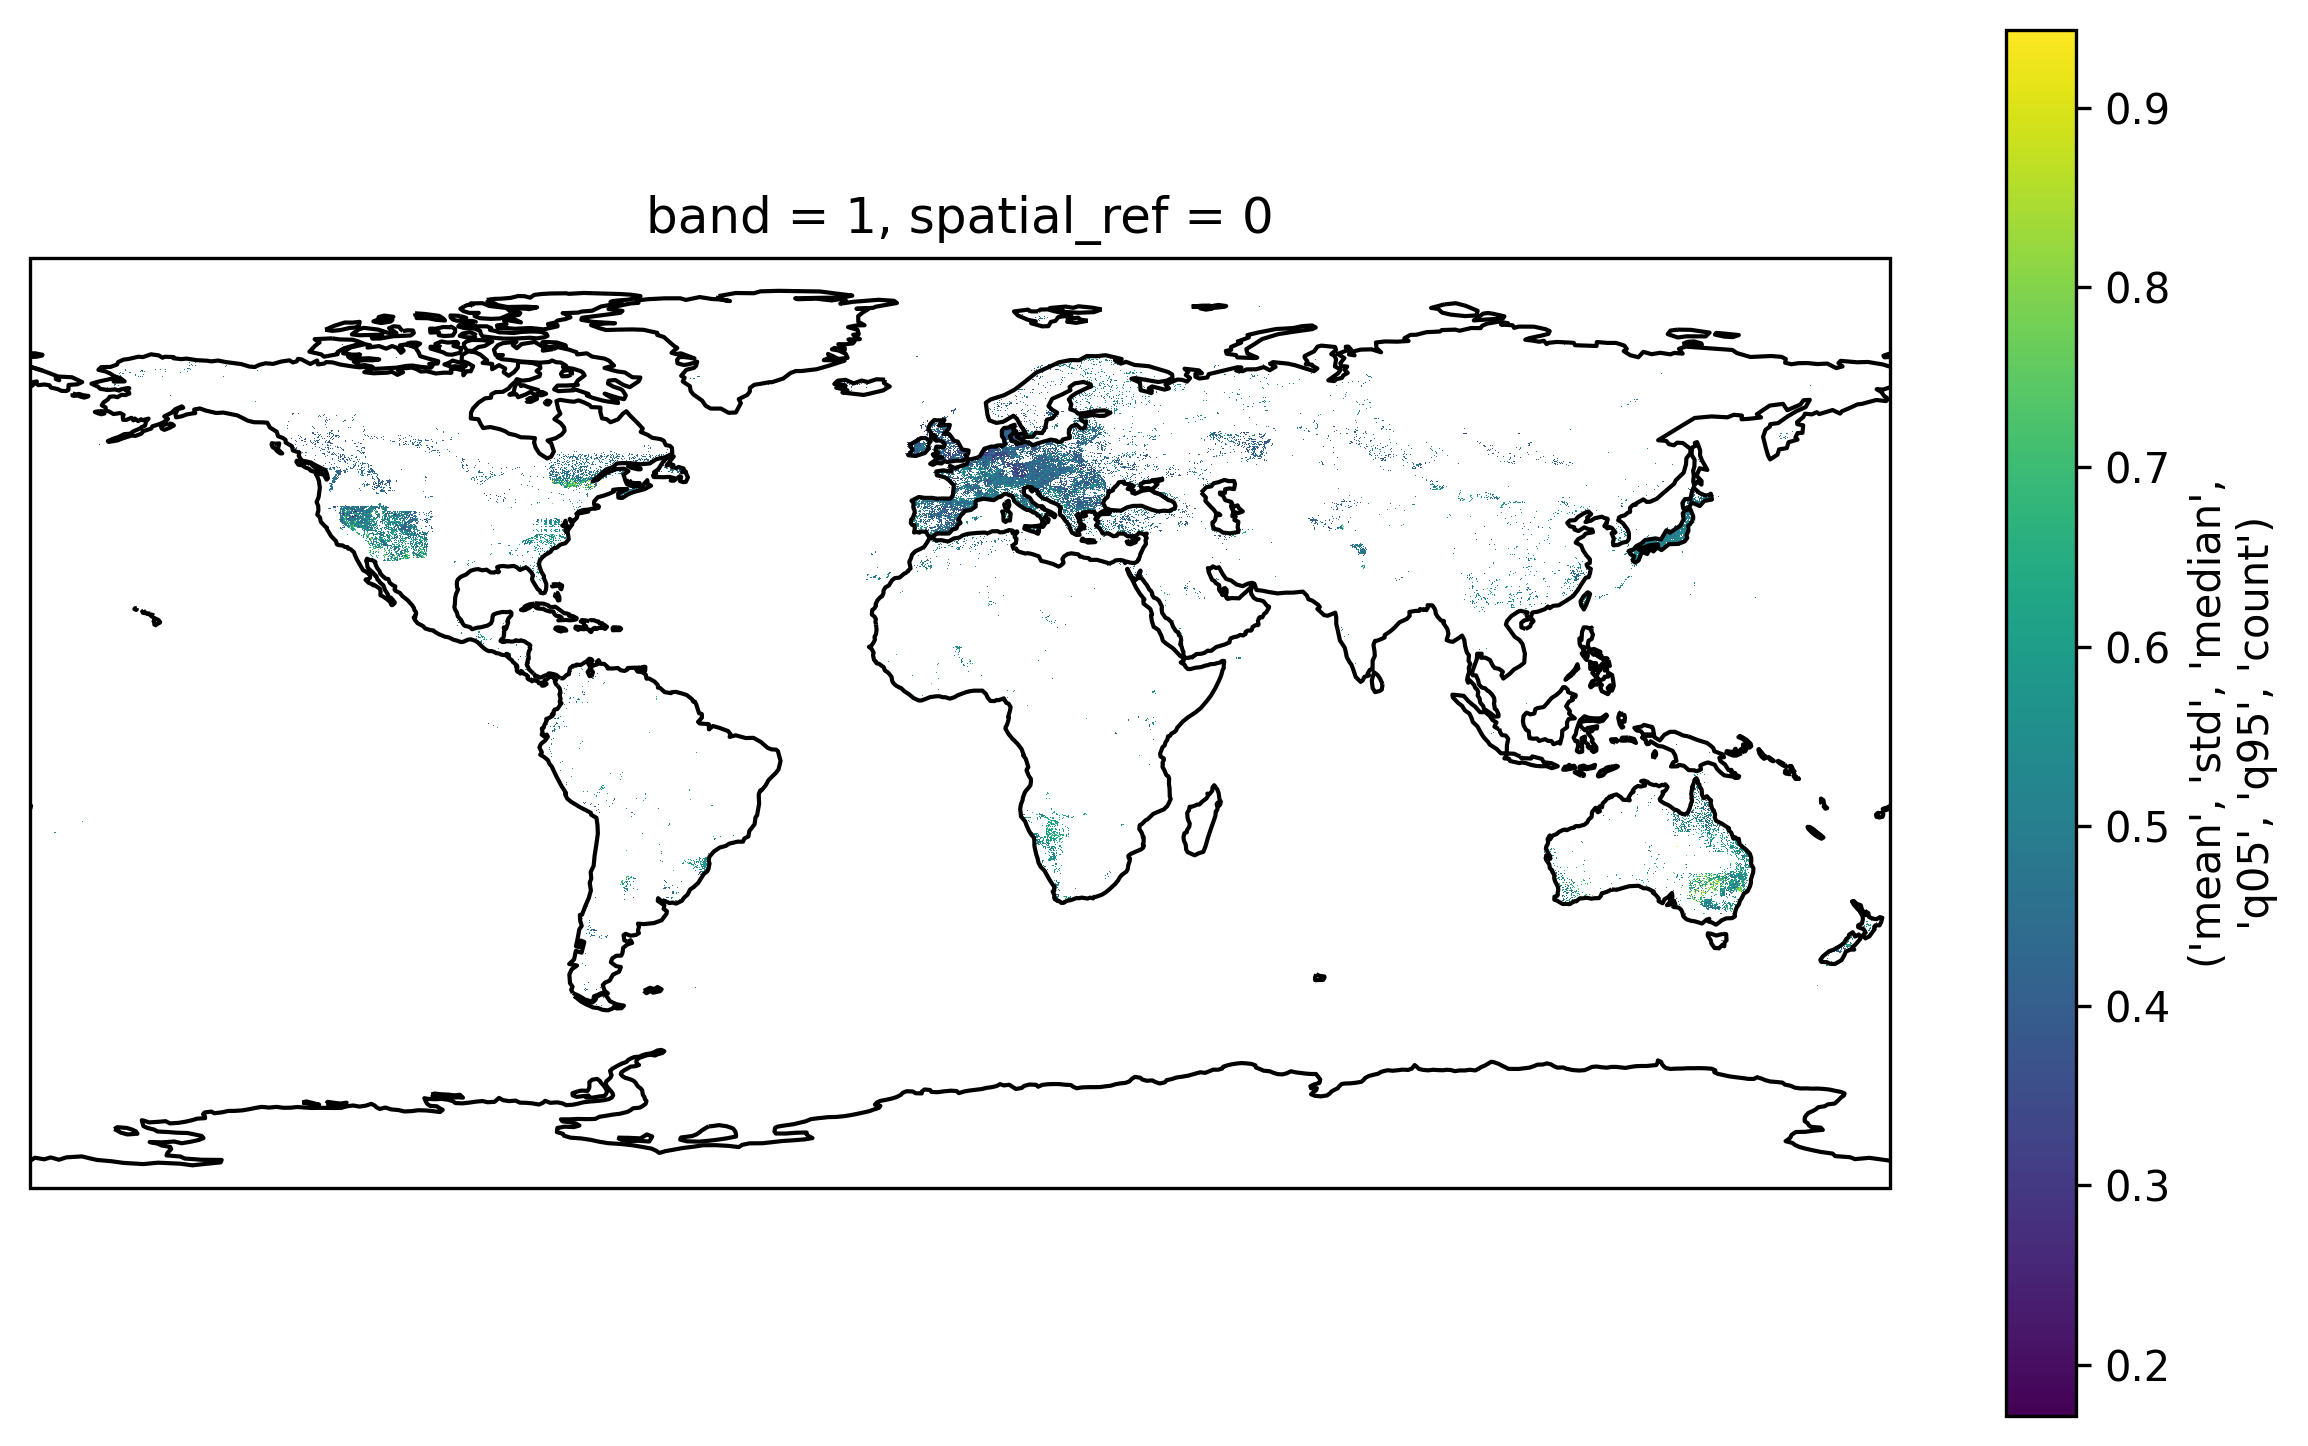

In [32]:
import rioxarray as riox
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

_, ax = plt.subplots(
    1, 1, subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300, figsize=(10, 6)
)
rast = riox.open_rasterio("X4.tif")

rast.sel(band=1).coarsen(x=10, y=10).mean().plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

In [16]:
# get sum of non-null values in rast
rast.sel(band=1).notnull().sum()

<xarray.DataArray ()> Size: 8B
array(193096)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0

In [15]:
rast.rio.bounds()

(-180.0, -90.0, 180.0, 90.0)

In [95]:
client.close()
cluster.close()